In [58]:
# 0) Setup
import os
import sys
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', 100)
DATA_FILE = os.getenv('EV_DATA_FILE', 'EV_Dataset.csv')
OUTPUT_DIR = Path('artifacts')
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"Using data file: {DATA_FILE}")
print(f"Artifacts will be saved to: {OUTPUT_DIR.resolve()}")


Using data file: EV_Dataset.csv
Artifacts will be saved to: D:\Internship\Electric Vehicle Sales\artifacts


In [59]:
# 1) Data Loading with helpful fallbacks
if not Path(DATA_FILE).exists():
    print('\n⚠️ Data file not found:', DATA_FILE)
    print('Please place your CSV as EV_Dataset.csv in this folder, OR set EV_DATA_FILE env var to the path.')
    # Create a tiny synthetic sample to let users run the notebook immediately
    sample = pd.DataFrame({
        'Year':[2022,2022,2023,2023],
        'Month_Name':['jan','feb','jan','feb'],
        'Date':['1/1/2022','2/1/2022','1/1/2023','2/1/2023'],
        'State':['Maharashtra','Karnataka','Uttar Pradesh','Rajasthan'],
        'Vehicle_Class':['MOTOR CAR','M-CYCLE/SCOOTER','MOTOR CAR','BUS'],
        'Vehicle_Category':['4-Wheelers','2-Wheelers','4-Wheelers','Bus'],
        'Vehicle_Type':['4W_Personal','2W_Personal','4W_Personal','Bus'],
        'EV_Sales_Quantity':[1200,3400,1800,260]
    })
    df = sample.copy()
    print('\n✅ Loaded synthetic sample (demo). Replace with real CSV for full analysis.')
else:
    df = pd.read_csv(DATA_FILE)
    print('\n✅ Data loaded from CSV:', DATA_FILE)

df.head()



✅ Data loaded from CSV: EV_Dataset.csv


,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
0,2014.0,jan,1/1/2014,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0
1,2014.0,jan,1/1/2014,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0
2,2014.0,jan,1/1/2014,Andhra Pradesh,AMBULANCE,Others,Others,0.0
3,2014.0,jan,1/1/2014,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0
4,2014.0,jan,1/1/2014,Andhra Pradesh,BUS,Bus,Bus,0.0


In [60]:
# 2) Quick Overview & Validation
print('Shape:', df.shape)
print('\nColumn dtypes before cleaning:')
print(df.dtypes)

print('\nMissing values per column:')
print(df.isna().sum())

# Basic sanity checks
assert 'EV_Sales_Quantity' in df.columns, 'Target column EV_Sales_Quantity missing.'
expected_cols = {'Year','Month_Name','Date','State','Vehicle_Class','Vehicle_Category','Vehicle_Type','EV_Sales_Quantity'}
missing = expected_cols - set(df.columns)
if missing:
    print('⚠️ Missing expected columns:', missing)
else:
    print('All expected columns present.')


Shape: (96845, 8)

Column dtypes before cleaning:
Year                 float64
Month_Name            object
Date                  object
State                 object
Vehicle_Class         object
Vehicle_Category      object
Vehicle_Type          object
EV_Sales_Quantity    float64
dtype: object

Missing values per column:
Year                 0
Month_Name           0
Date                 0
State                0
Vehicle_Class        0
Vehicle_Category     0
Vehicle_Type         0
EV_Sales_Quantity    0
dtype: int64
All expected columns present.


In [61]:
# 3) Cleaning & Type Casting
df = df.copy()

# Year → int (when safe)
if 'Year' in df.columns:
    try:
        df['Year'] = df['Year'].astype(float).astype(int)
    except Exception as e:
        print('Year casting warning:', e)

# Date → datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=False, infer_datetime_format=True)

# Whitespace trimming for object columns
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

# Handle missing numerics: fill EV_Sales_Quantity with 0 if missing
if df['EV_Sales_Quantity'].isna().any():
    df['EV_Sales_Quantity'] = df['EV_Sales_Quantity'].fillna(0)

print('Dtypes after cleaning:')
print(df.dtypes)


Dtypes after cleaning:
Year                          int32
Month_Name                   object
Date                 datetime64[ns]
State                        object
Vehicle_Class                object
Vehicle_Category             object
Vehicle_Type                 object
EV_Sales_Quantity           float64
dtype: object


C:\Users\HP\AppData\Local\Temp\ipykernel_14384\1200605942.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=False, infer_datetime_format=True)


In [62]:
# Helper: safe bar labeling
def _bar_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        if not math.isnan(height):
            ax.annotate(f'{int(height)}', (p.get_x()+p.get_width()/2., height),
                        ha='center', va='bottom', fontsize=8, rotation=0)


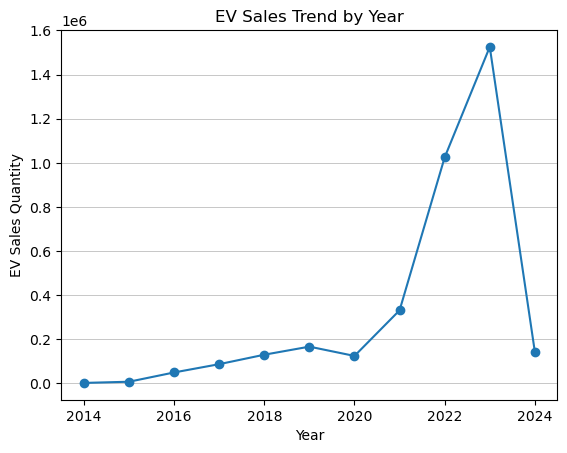

,Year,EV_Sales_Quantity
0,2014,2392.0
1,2015,7805.0
2,2016,49855.0
3,2017,87420.0
4,2018,130254.0
5,2019,166819.0
6,2020,124684.0
7,2021,331498.0
8,2022,1024723.0
9,2023,1525179.0


In [63]:
# 4) Yearly trend of EV sales
if 'Year' in df.columns:
    yearly = df.groupby('Year', as_index=False)['EV_Sales_Quantity'].sum()
    plt.figure()
    plt.plot(yearly['Year'], yearly['EV_Sales_Quantity'], marker='o')
    plt.title('EV Sales Trend by Year')
    plt.xlabel('Year')
    plt.ylabel('EV Sales Quantity')
    plt.grid(True, axis='y', linewidth=0.5)
    plt.show()
    display(yearly.sort_values('Year'))
else:
    print('Year column not available for trend plot.')


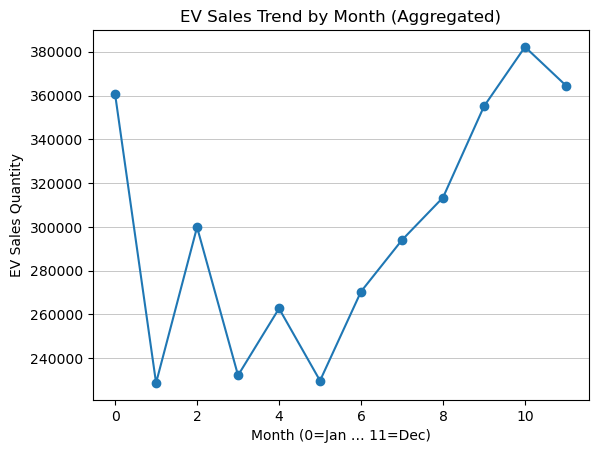

,Month,EV_Sales_Quantity
0,JAN,360703.0
1,FEB,228739.0
2,MAR,299888.0
3,APR,232194.0
4,MAY,262747.0
5,JUN,229754.0
6,JUL,270473.0
7,AUG,294022.0
8,SEP,313433.0
9,OCT,355083.0


In [64]:
# 5) Monthly trend (aggregated)
if 'Month_Name' in df.columns:
    order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    month_map = {m:i for i,m in enumerate(order)}
    s = df['Month_Name'].str.lower()
    mon = s.map(month_map)
    df['_mon_idx'] = mon
    monthly = df.groupby('_mon_idx', as_index=False)['EV_Sales_Quantity'].sum().dropna()
    plt.figure()
    plt.plot(monthly['_mon_idx'], monthly['EV_Sales_Quantity'], marker='o')
    plt.title('EV Sales Trend by Month (Aggregated)')
    plt.xlabel('Month (0=Jan … 11=Dec)')
    plt.ylabel('EV Sales Quantity')
    plt.grid(True, axis='y', linewidth=0.5)
    plt.show()
    monthly['Month'] = monthly['_mon_idx'].map({i:m.upper() for i,m in enumerate(order)})
    display(monthly[['Month', 'EV_Sales_Quantity']])
    df.drop(columns=['_mon_idx'], errors='ignore', inplace=True)
else:
    print('Month_Name column not available for monthly plot.')


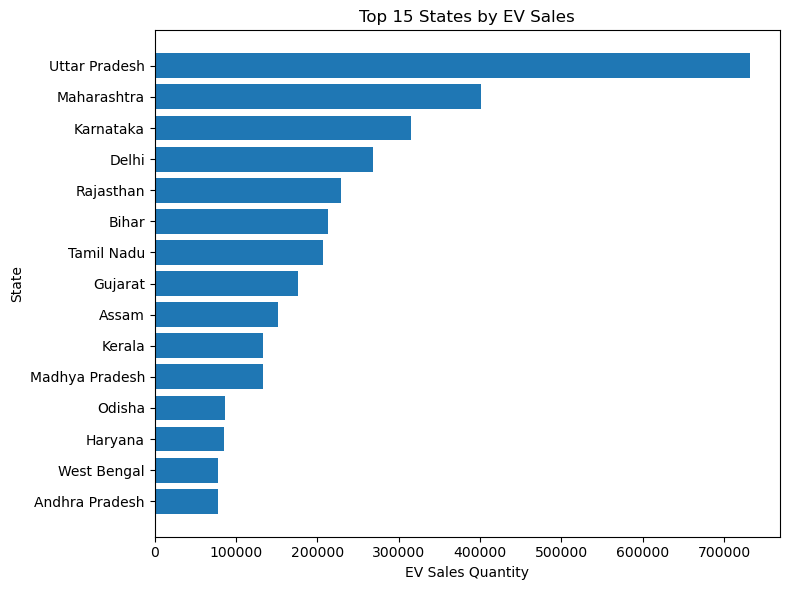

,State,EV_Sales_Quantity
31,Uttar Pradesh,732074.0
19,Maharashtra,401535.0
15,Karnataka,315498.0
8,Delhi,268538.0
27,Rajasthan,228573.0
4,Bihar,213465.0
29,Tamil Nadu,206902.0
10,Gujarat,176713.0
3,Assam,151917.0
16,Kerala,133246.0


In [65]:
# 6) Top 15 states by total EV sales
if 'State' in df.columns:
    st = df.groupby('State', as_index=False)['EV_Sales_Quantity'].sum()
    top_states = st.sort_values('EV_Sales_Quantity', ascending=False).head(15)
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.barh(top_states['State'][::-1], top_states['EV_Sales_Quantity'][::-1])
    plt.title('Top 15 States by EV Sales')
    plt.xlabel('EV Sales Quantity')
    plt.ylabel('State')
    plt.tight_layout()
    plt.show()
    display(top_states)
else:
    print('State column not available.')


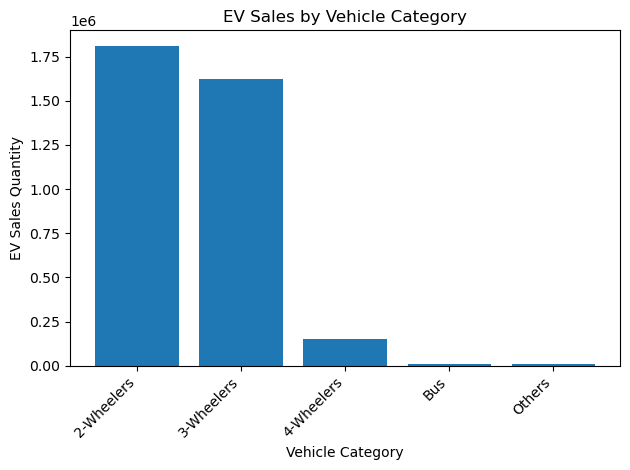

,Vehicle_Category,EV_Sales_Quantity
0,2-Wheelers,1808105.0
1,3-Wheelers,1620310.0
2,4-Wheelers,149775.0
4,Others,8612.0
3,Bus,7009.0


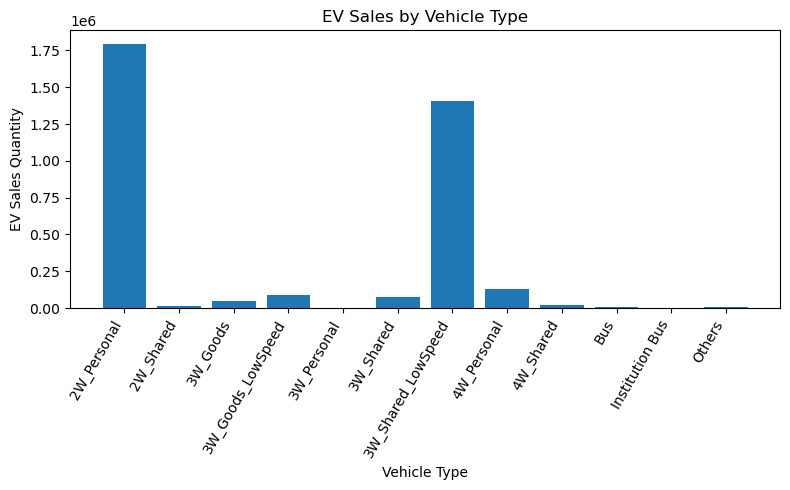

,Vehicle_Type,EV_Sales_Quantity
0,2W_Personal,1796340.0
6,3W_Shared_LowSpeed,1408127.0
7,4W_Personal,130676.0
3,3W_Goods_LowSpeed,90656.0
5,3W_Shared,76132.0
2,3W_Goods,44974.0
8,4W_Shared,19099.0
1,2W_Shared,11765.0
11,Others,8612.0
9,Bus,7009.0


In [66]:
# 7) Category & Type distributions
if 'Vehicle_Category' in df.columns:
    cat = df.groupby('Vehicle_Category', as_index=False)['EV_Sales_Quantity'].sum()
    plt.figure()
    plt.bar(cat['Vehicle_Category'], cat['EV_Sales_Quantity'])
    plt.title('EV Sales by Vehicle Category')
    plt.xlabel('Vehicle Category')
    plt.ylabel('EV Sales Quantity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    display(cat.sort_values('EV_Sales_Quantity', ascending=False))

if 'Vehicle_Type' in df.columns:
    vtyp = df.groupby('Vehicle_Type', as_index=False)['EV_Sales_Quantity'].sum()
    plt.figure(figsize=(8,5))
    plt.bar(vtyp['Vehicle_Type'], vtyp['EV_Sales_Quantity'])
    plt.title('EV Sales by Vehicle Type')
    plt.xlabel('Vehicle Type')
    plt.ylabel('EV Sales Quantity')
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()
    display(vtyp.sort_values('EV_Sales_Quantity', ascending=False))


In [67]:
from sklearn.preprocessing import LabelEncoder

df_fe = df.copy()

# Extract date features
if 'Date' in df_fe.columns and pd.api.types.is_datetime64_any_dtype(df_fe['Date']):
    df_fe['Year_num'] = df_fe['Date'].dt.year
    df_fe['Month_num'] = df_fe['Date'].dt.month
    df_fe['Day_num'] = df_fe['Date'].dt.day
else:
    df_fe['Year_num'] = df_fe.get('Year', pd.Series([np.nan]*len(df_fe)))
    month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
    if 'Month_Name' in df_fe.columns:
        df_fe['Month_num'] = df_fe['Month_Name'].astype(str).str.lower().map(month_map)
    df_fe['Day_num'] = 1

# Label encode categorical columns
cat_cols = ['State','Vehicle_Class','Vehicle_Category','Vehicle_Type','Month_Name']
for col in cat_cols:
    if col in df_fe.columns:
        le = LabelEncoder()
        df_fe[col] = le.fit_transform(df_fe[col].astype(str))

# Drop unused raw Date
drop_cols = [c for c in ['Date'] if c in df_fe.columns]
X = df_fe.drop(columns=['EV_Sales_Quantity'] + drop_cols)
y = df_fe['EV_Sales_Quantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print({
    'MAE': round(mean_absolute_error(y_test, pred),3),
    'RMSE': round(mean_squared_error(y_test, pred, squared=False),3),
    'R2': round(r2_score(y_test, pred),4)
})


{'MAE': 11.422, 'RMSE': 123.25, 'R2': 0.9417}


d:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


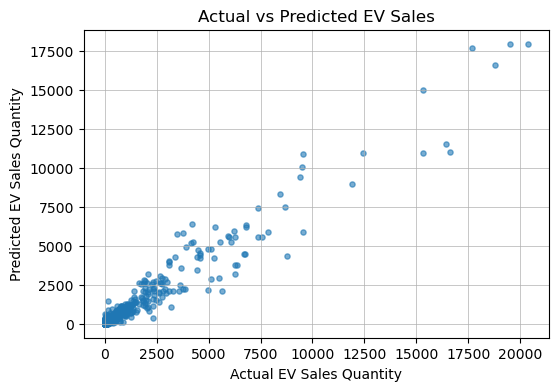

In [68]:
# 9) Actual vs Predicted scatter
plt.figure(figsize=(6,4))
plt.scatter(y_test, pred, s=14, alpha=0.6)
plt.title('Actual vs Predicted EV Sales')
plt.xlabel('Actual EV Sales Quantity')
plt.ylabel('Predicted EV Sales Quantity')
plt.grid(True, linewidth=0.5)
plt.show()


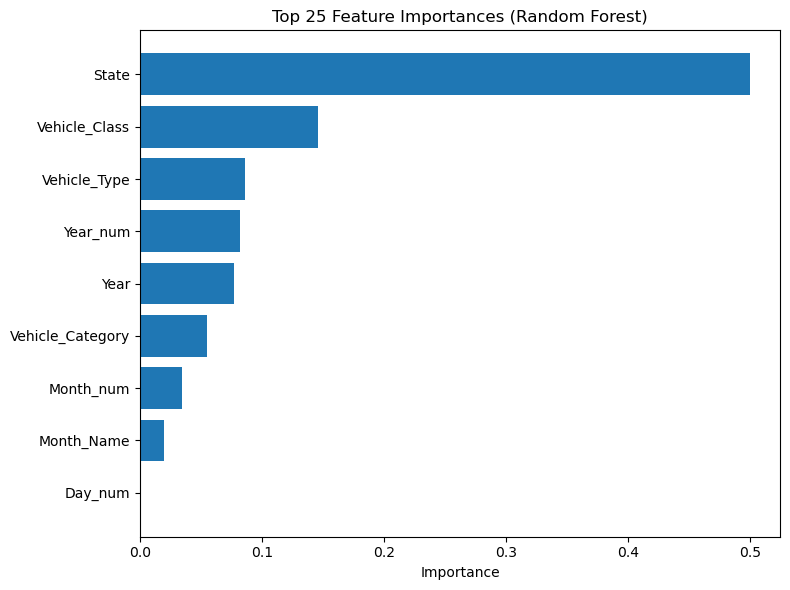

State               0.499596
Vehicle_Class       0.146155
Vehicle_Type        0.086126
Year_num            0.082144
Year                0.077096
Vehicle_Category    0.054850
Month_num           0.034704
Month_Name          0.019329
Day_num             0.000000
dtype: float64

In [69]:
# 10) Feature importances (top 25)
importances = getattr(model, 'feature_importances_', None)
if importances is not None:
    fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)[:25]
    plt.figure(figsize=(8,6))
    plt.barh(fi.index[::-1], fi.values[::-1])
    plt.title('Top 25 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    display(fi)
else:
    print('Model does not expose feature_importances_.')


In [74]:
# 11) Export artifacts: processed data + model (optional)

import joblib

# Save processed dataset as compressed Parquet
processed_path = OUTPUT_DIR / 'ev_processed.parquet'
df_model.to_parquet(processed_path, index=False, compression="snappy")
print("✅ Saved processed dataset to:", processed_path.resolve())

# Save trained model as .pkl
model_path = OUTPUT_DIR / 'rf_model.pkl'
joblib.dump(model, model_path)
print("✅ Saved trained RandomForest model to:", model_path.resolve())


✅ Saved processed dataset to: D:\Internship\Electric Vehicle Sales\artifacts\ev_processed.parquet
✅ Saved trained RandomForest model to: D:\Internship\Electric Vehicle Sales\artifacts\rf_model.pkl
